# Breif intro to deep nueral networks

<img src="./figure/table.png" />

for this class we will focus on supervised learning. More specifically, we will use some classification models to expain the main concepts of deep learning

A deep learning model is constructed by three main parts,model structure, loss function, and optimization.
<img src=https://eenews.cdnartwhere.eu/sites/default/files/images/01-picture-library/ChristophHammerschmidt/2016-11-november/Cadence_Hijazi/cnn_fig1.jpeg />

# Convolutional Neural Networks for regulatory genomics

In this notebook, we will walk through how to build, train, and evaluate a convolutional neural network (CNN) for the computational task of predicting transcription factor binding sites from Chromatin Immunoprecipitation sequencing (ChIP-seq) data.



In [ ]:
import h5py # python module needed to load dataset (stored in an hdf5 file format)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


#### Overview
Here, we will employ a CNN model to experimental ChIP-seq data for CTCF, a transciption factor that is known to bind to DNA and help form loops. We will set this up as a supervised learning task, specifically a binary classification, where we give the model a sequence and it has to predict whether or not it is associated with TF binding (i.e. presence or absence of a ChIP-seq peak). Thus, we need a set of background sequences which don't have a ChIP-seq peak. 

________________________________________________________________________________
#### How should we choose background sequences?

Randomly choosing sequences throughout the genome may include a CTCF motif (the accessibility of DNA is different across cell-types). If the properties of the background sequences are different from the positive sequences (e.g. GC-content differences), then a model may learn this instead of the motif patterns. We could just shuffle the sequences, but we may end up with a model that learns real genomic sequences vs fake genomic sequences. One background sequence that makes sense is to use accessible chromatin in the same cell type BUT does not overlap with the TF binding sites from ChIP-seq.  This way, the background sequences come from regulatory DNA from the same cell type and the only presumable difference between background and positive sequences is the TF binding site.  

Fortunately for you, we already did this and processed the dataset:

1. we took the narrowpeaks bed file for [CTCF]((https://www.encodeproject.org/experiments/ENCSR000BIE/) and the [DNase-seq](https://www.encodeproject.org/experiments/ENCSR149XIL/) narrow peaks bed file for HepG2 cells from ENCODE.  
2. we used [bedtools](https://bedtools.readthedocs.io/en/latest/) to find the DNase peaks that do not overlap with a CTCF peak, which will serve as our negative set.  
3. we fixed the size of each bed entry to 200 nts. This is necessary for our CNN which requires a fixed-length input. The distribution of peaks falls within this range so it seems like it is a reasonable size.  
4. we filter sequences that contain an 'N' character and convert the remaining sequences into a one-hot representation, using the alphabet 'ACGT'.  For example, a sequence AGGTC would be converted to: [[1,0,0,0], [0,0,1,0], [0,0,1,0], [0,0,0,1], [0,1,0,0]]. This sequence has a shape (1,L,A). 
5. We give each sequence a label 1 for positive sequence and 0 for background sequence. 
6. We randomly select the same number of background sequences as positive sequences so that we can keep the number of training examples balanced. 
7. we randomly split the data into a training set, validation set, and test set according to proportions 0.7, 0.1, 0.2, respectively. 
8. The dataset is stored in an hdf5 file -- a format that is conducive for big data file handling.

________________________________________________________________________________

Let's download the data:




In [ ]:
!wget https://www.dropbox.com/s/0ks4dk6md2l9mqx/CTCF_200.h5

--2020-10-16 19:37:10--  https://www.dropbox.com/s/0ks4dk6md2l9mqx/CTCF_200.h5
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/0ks4dk6md2l9mqx/CTCF_200.h5 [following]
--2020-10-16 19:37:10--  https://www.dropbox.com/s/raw/0ks4dk6md2l9mqx/CTCF_200.h5
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1bf4aff87f44ac4179521118c4.dl.dropboxusercontent.com/cd/0/inline/BBZzcz7S0-iHZN6OJ2plZ8Pd8FXkiQFT7CfPw3FsWn3a36DJ1bO82hxPFmUFqL0r5asGzfiwvoeTH4nmbsYX48sAmBOia4f0vmHA1HmqbyuLiysqUdS8R10XYrQh5qX9EeM/file# [following]
--2020-10-16 19:37:10--  https://uc1bf4aff87f44ac4179521118c4.dl.dropboxusercontent.com/cd/0/inline/BBZzcz7S0-iHZN6OJ2plZ8Pd8FXkiQFT7CfPw3FsWn3a36DJ1bO82hxPFmUFqL0r5asGzfiwvoeTH4nmbsYX48sAmBOia4f0vmHA1HmqbyuLiysqUdS8R

For this dataset, the keys for the train sequences is x_train and its corresponding label is y_train.  Note that the transpose changes the shape of the sequences such that the shape is (N,L,A), where N is the number of sequences, L is the length of the sequence=200, and A is the alphabet size=4). 

We define the alphabet which was used to generate the dataset (dim0=A, dim1=C, dim2=G, dim3=T)



In [ ]:
# load dataset
file_path = 'CTCF_200.h5'
dataset = h5py.File(file_path, 'r')
x_train = np.array(dataset['x_train']).transpose([0,2,1])
y_train = np.array(dataset['y_train'])
x_valid = np.array(dataset['x_valid']).transpose([0,2,1])
y_valid = np.array(dataset['y_valid'])
x_test = np.array(dataset['x_test']).transpose([0,2,1])
y_test = np.array(dataset['y_test'])

alphabet = 'ACGT'

# print shape of training data
print(x_train.shape)

(51156, 200, 4)


There should be 51,156 training sequences each 200 nts long with an alphabet size of 4. Let's see what a sequence actually looks like:

In [ ]:
print(x_train)

[[[0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  ...
  [0. 1. 0. 0.]
  [0. 0. 0. 1.]
  [0. 1. 0. 0.]]

 [[0. 0. 1. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  ...
  [0. 0. 0. 1.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]]

 [[0. 1. 0. 0.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  ...
  [0. 1. 0. 0.]
  [0. 0. 0. 1.]
  [1. 0. 0. 0.]]

 ...

 [[0. 1. 0. 0.]
  [0. 0. 0. 1.]
  [0. 0. 1. 0.]
  ...
  [1. 0. 0. 0.]
  [0. 0. 0. 1.]
  [1. 0. 0. 0.]]

 [[0. 1. 0. 0.]
  [0. 0. 0. 1.]
  [0. 0. 1. 0.]
  ...
  [0. 0. 0. 1.]
  [0. 0. 1. 0.]
  [1. 0. 0. 0.]]

 [[0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [1. 0. 0. 0.]
  ...
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 0. 1. 0.]]]


Now let's look at the shape of the training labels (y).

In [ ]:
print(y_train.shape)
print(y_train)

(51156, 1)
[[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [0]]


# Convolutional Neural Network Overview

A convolutional neural network (CNN) is composed of a stack of convolutional modules, each of which perform feature extraction from the previous layer. Each module consists of a convolutional layer, non-linear activation, followed by an optional pooling layer. The convolutional modules are usually followed by one or more dense layers which help it to learn more complex features. The final dense layer in a CNN is where predictions of the model are made. The activations of the output layer depend on the task at hand. In binary classification of TF binding sites, it will be a sigmoid activation (similar to logistic regression).

### Convolutional layer

Convolutional layers employ a specified number of convolution filters. The output of the convolutional filter scans is called a feature map. Convolutional layers then typically apply a ReLU activation function to the feature maps. Convolutional layers have 4 main hyperparameter choices: number of filters, filter size (i.e. kernel_size), padding, and activation. 

Eg. Conv1D(filters=24, kernel_size=19, activation='relu', padding='same')

- The number of filters specifies how many patterns you aim to capture in that layer.  
- The kernel_size sets how large you expect the important patterns to be in the given layer. 
- The padding argument specifies one of two enumerated values: valid (default) or same. To specify that the output tensor should have the same width and height values as the input tensor, we set padding=same, which instructs TensorFlow to pad the sequences with 0 values at the edges to preserve the shape of the sequence. 
- The activation sets the non-linearity added after the convolutional scans. The default is linear. We will use rectified linear units (ReLU) here. Other choices include: sigmoid, tanh, elu, softplus, swish, prelu, leaky relu.

### Max-pool layer

Max-pooling is a technique to downsample the data over a window size set by pool_size. This allows for deeper convolutional layers to learn patterns over a larger sequence context, while significantly reducing the processing time. The strides of max pooling sets how many steps to take for each max-pool operation. If the strides is set to the pool_size, this creates non-overlapping windows of the feature maps. Here, we will downsample the 1st convolutional layer scans by non-overlapping windows of size 25. This will result in a shape of (N, L/25, A).

Eg. layers.MaxPool1D(pool_size=25)

### fully-connected hidden layer

Dense (fully connected) layers, connect every node in the layer (set by num_units) to every node in the preceding layer. The hyperparameters of interest are the number of neurons (units) and the activation, which we will set to relu.

layers.Dense(units=64, activation='relu')

FYI, most hyperparameter settings for convolutional, max-pooling, and dense layers are chosen through trail-and-error. Most settings result in similar performance -- they are all nearly just as good as each other. Finding the jackpot setting usually means you improve accuracy from 0.9 to 0.92.  


### fully-connected output layer

The output layer is a linear classifier model. So, the number of predictions we want to make is the number of output neurons we need to create. Here that number is one, because we are only making a single prediction -- whether or not a sequence is associated with a CTCF ChIP-seq peak. If there were more labels, all we have to do is set the 1 to an appropriate value. Note that the activation is dependent on what you are trying to predict. For instance, a regression can be achieved by a simple linear model, without any activation; a binary classificaiton can be achieved with a sigmoid activation, a multi-class prediction can be achieved with a softmax activation. Here we are performing a single-class binary classification, so we will employ sigmoid activations to the output neuron.

layers.Dense(units=1, activation='linear')
layers.Activation('sigmoid')



For more details on CNNs: https://cs231n.github.io/convolutional-networks/
Dataset overview




In [ ]:
from tensorflow import keras

# import modules that will make it easy to build and train the linear regression model
from tensorflow.keras import models, layers

# let's setup a sequential model -- which means that the model will be feed 
# forward (all models in this course will be sequential)
model = models.Sequential()

# the input layer specifies the shape of the input data to the model. Since our input 
# features, x, are 1-dimensional, we can set this value to 1. All models require
# some input layer (where you feed in data).
model.add(layers.InputLayer(input_shape=(200,4)))
model.add(layers.Conv1D(filters=24, kernel_size=19, activation='relu', padding='same'))
model.add(layers.MaxPool1D(pool_size=25))
model.add(layers.Flatten())
model.add(layers.Dense(units=64, activation='relu'))

# a dense connection to 1 unit means that the inputs are fully connected to the 
# output neuron (in this case a single output neuron). Linear is the default 
# activation, but here we explicitly write it.
model.add(layers.Dense(units=1, activation='linear'))
model.add(layers.Activation('sigmoid'))

After we build the model, we can print a summary that shows the order of the layers, the shapes and number of parameters:

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 200, 24)           1848      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 8, 24)             0         
_________________________________________________________________
flatten (Flatten)            (None, 192)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                12352     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 14,265
Trainable params: 14,265
Non-trainable params: 0
____________________________________________________

### Build loss function

For both training and evaluation, we need to define a loss function that measures how closely the model's predictions match the target classes. This is usually a log-likelihood function for supervised learning. The log-likelihood for a binary classification is the binary cross-entropy loss function:

$\mathcal{L} = \sum_i y_i \log(p_i) + (1-y_i)\log(1-p_i)$

Fortunately, Keras makes this super easy as you'll see below.

### Build optimizer

Now that we have our loss function established, we need to be able to calculate the gradients of the loss function with respect to the parameters of the model, which is efficiently calculated with backpropagation. Then, we can update the weights with gradients scaled by the learning rate, which is known as gradient descent learning. Fortunately, tensorflow/Keras provides a nice wrapper to perform all of this. There are many built in optimizers: sgd, momentum, adam, adagrad, rmsprop. ADAM is the best introductory optimizer for most tasks. It performs an adaptive learning rate based on previous gradients and hence it is much faster to converge and leads to consistently good solutions.  

For more info on adam: https://towardsdatascience.com/adam-latest-trends-in-deep-learning-optimization-6be9a291375c

In [ ]:
# Now that we built the model, we have to set up the loss function and the optimizer.
# Since it's a linear regression, we will set it to 'mean_squared_error'. 
# we will set the optimizer to stochastic gradient descent 'sgd' (even though this
# is unnecessary for a linear regression)

loss = keras.losses.BinaryCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate=0.001)
auroc = keras.metrics.AUC(curve='ROC', name='auroc')
model.compile(loss=loss, optimizer=optimizer, metrics=[auroc])

# a short cut is: model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[auroc])

### Fit the model

We want to train our CNN model with mini-batch stochastic gradient descent. So, we need a way to generate mini-batches of data. Keras handles all of this for you through the setting batch_size. It also lets you select the number of epochs to train.  You can also monitor validation performance by adding the validation_data flag.  

In [ ]:
# Now let's fit the model. The main inputs are x, y, epochs, which sets the number 
# of times to run through the dataset with SGD. Also, we set verbose to false,
# because too many outputs are written and it is overwhelming for a linear model.
# We will turn this flag to true for other datasets later.
model.fit(x_train, y_train, batch_size=100, epochs=30, validation_data=(x_valid, y_valid))

Epoch 1/30
512/512 [==============================] - 2s 5ms/step - loss: 0.3838 - auroc: 0.9095 - val_loss: 0.2271 - val_auroc: 0.9703
Epoch 2/30
512/512 [==============================] - 2s 4ms/step - loss: 0.2040 - auroc: 0.9744 - val_loss: 0.1869 - val_auroc: 0.9802
Epoch 3/30
512/512 [==============================] - 2s 4ms/step - loss: 0.1710 - auroc: 0.9814 - val_loss: 0.1631 - val_auroc: 0.9835
Epoch 4/30
512/512 [==============================] - 2s 4ms/step - loss: 0.1564 - auroc: 0.9840 - val_loss: 0.1523 - val_auroc: 0.9851
Epoch 5/30
512/512 [==============================] - 2s 4ms/step - loss: 0.1429 - auroc: 0.9863 - val_loss: 0.1570 - val_auroc: 0.9859
Epoch 6/30
512/512 [==============================] - 2s 4ms/step - loss: 0.1365 - auroc: 0.9873 - val_loss: 0.1438 - val_auroc: 0.9868
Epoch 7/30
512/512 [==============================] - 2s 4ms/step - loss: 0.1302 - auroc: 0.9882 - val_loss: 0.1413 - val_auroc: 0.9868
Epoch 8/30
512/512 [============================

KeyboardInterrupt: ignored

### Evaluate model

Evaluating the test performance is easy with Keras. See below:

In [ ]:
# evaluate model
model.evaluate(x_test, y_test)

74/74 [==============================] - 0s 3ms/step - loss: 0.1701 - auroc: 0.9836


[0.1701124757528305, 0.983579158782959]

# Validating the model

To validate what the network is learning let's calculate a saliency map --  derivative of the output neuron with respect to the inputs. Luckily, tensorflow makes this easy because it calculates gradients using automatic differentiation. We can calculate the gradient with the function model.optimizer.get_gradients. We need to create a keras function to execute this. See code below:


In [ ]:
import tensorflow.keras.backend as K

# create an op to calculate gradients of outputs with respect to inputs (i.e. saliency map)
# Note that we are taking the derivative of the pre-activated output layer (not the output layer)
# this is because the sigmoid can make the gradients very small when predictions are close to 1 or 0
gradients = model.optimizer.get_gradients(model.layers[-2].output, model.input)

# create a keras function to execute gradients
compute_gradients = K.function(inputs=model.input, outputs=gradients)

Now we should choose which sequences we want to perform saliency analysis on. Let's choose the top 10 test sequences with the highest predictions. To find these, we can first predict the test sequences, sort them in descending order, then slice the top ten.

In [ ]:
# To get model predictions, we can simply call predict.
predictions = model.predict(x_test)

# sort predictions in decending order
index = np.argsort(predictions[:,0])[::-1]

# get the top num_plot predictions
num_plots = 10
X = x_test[index[:num_plots]]

# calculate saliency maps
saliency_map = compute_gradients(X)[0]

Let's visualize the saliency maps. We can plot this as a heat map:

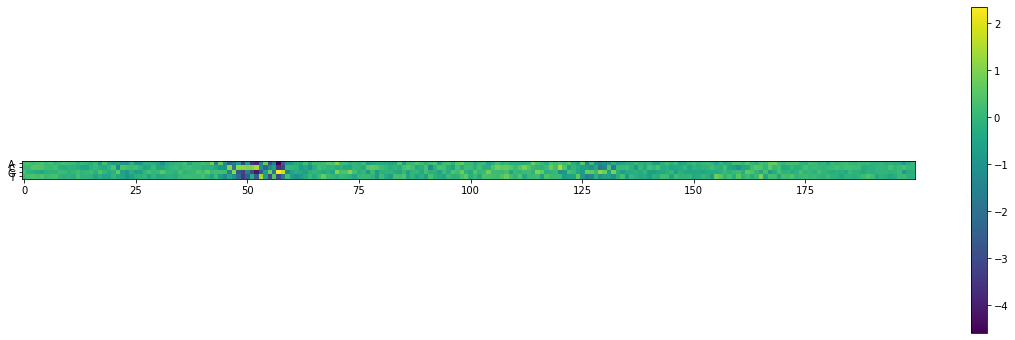

In [ ]:
plt.figure(figsize=(20,6))
plt.imshow(saliency_map[0].T)
plt.yticks([0,1,2,3], alphabet)
plt.colorbar()

This isn't a very nice visualization. Fortunately for you, [Logomaker](https://logomaker.readthedocs.io/en/latest/) (by Tareen and Kinney) can help us visualize saliency maps. We need to first install it on Google Colab.

In [ ]:
!pip install logomaker

     |████████████████████████████████| 11.8MB 262kB/s 


I have created a function to visualize the saliency maps.  You are welcome to take a look at it. It essentially just converts the saliency map in the format needed by logomaker. 

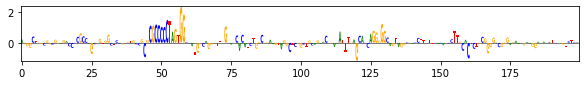

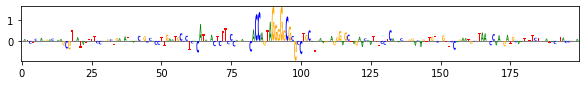

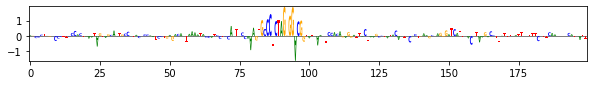

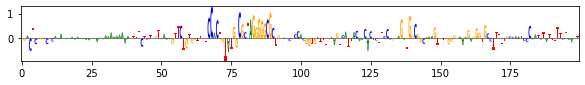

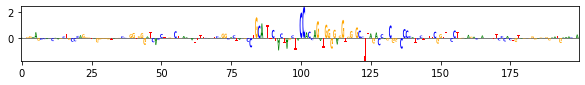

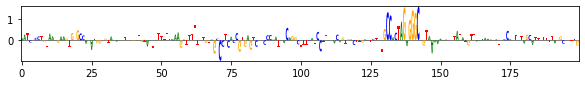

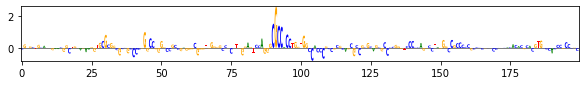

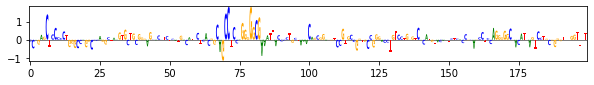

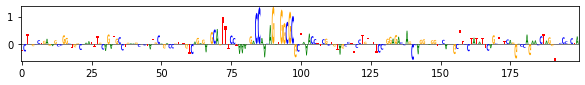

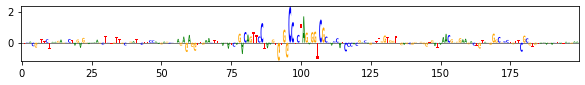

In [ ]:
import pandas as pd
import logomaker 

def plot_saliency_map(scores, alphabet, ax=None):
  L,A = scores.shape
  counts_df = pd.DataFrame(data=0.0, columns=list(alphabet), index=list(range(L)))
  for a in range(A):
    for l in range(L):
      counts_df.iloc[l,a] = scores[l,a]

  if not ax:
    ax = plt.subplot(1,1,1)
  logomaker.Logo(counts_df, ax=ax)


saliency_scores = saliency_map * X  # grad * input
for scores in saliency_scores:
  fig = plt.figure(figsize=(10,1))
  ax = plt.subplot(1,1,1)
  plot_saliency_map(scores, alphabet, ax)

Now while these saliency plots seem to find a motif pattern that resembles the CTCF motif (see: https://www.factorbook.org/tf/human/CTCF/motif/ENCSR000BIE), the saliency maps are really noisy.  From my experience, this arises because of overfitting, which leads to spurious saliency maps as well -- here overfitting does not affect classification performance on the test set and is termed benign overfitting.

# Redo analysis

Let's redo this analysis with some regularization added to our CNN model. A very effective regularization is dropout and early stopping. For convolutional layers, let's add a dropout rate of 0.2 and for dense layers let's use a dropout of 0.5.  For early stopping, there is a built in "callback" in keras. Callbacks are objects taht perform actions during training. The early stopping call back checks whether the model's validation performance hasn't improved for x number of epochs. if the x number of epochs exceeds your patience, then training loop is stopped.  See below for example code.

In [ ]:
from tensorflow import keras
from tensorflow.keras import models, layers

# build model
model = models.Sequential()
model.add(layers.InputLayer(input_shape=(200,4)))
model.add(layers.Conv1D(filters=24, kernel_size=19, activation='relu', padding='same'))
model.add(layers.MaxPool1D(pool_size=25))
model.add(layers.Dropout(0.2))   # <-- add 0.1-0.2 for conv layers
model.add(layers.Flatten())
model.add(layers.Dense(units=64, activation='relu'))
model.add(layers.Dropout(0.5))  # <-- add 0.1-0.5 for dense layers
model.add(layers.Dense(units=1, activation='linear'))
model.add(layers.Activation('sigmoid'))

# compile model
auroc = keras.metrics.AUC(curve='ROC', name='auroc')
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[auroc])

# create a callback for early stopping. Now we can increase the number of epochs 
# as early stopping will automatically stop training earlier
es_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5)

# fit model
model.fit(x_train, y_train, batch_size=128, epochs=100, 
          validation_data=(x_valid, y_valid),
          callbacks=es_callback)

Epoch 1/100
400/400 [==============================] - 2s 5ms/step - loss: 0.4487 - auroc: 0.8696 - val_loss: 0.2185 - val_auroc: 0.9740
Epoch 2/100
400/400 [==============================] - 2s 4ms/step - loss: 0.2193 - auroc: 0.9706 - val_loss: 0.1685 - val_auroc: 0.9830
Epoch 3/100
400/400 [==============================] - 2s 4ms/step - loss: 0.1860 - auroc: 0.9783 - val_loss: 0.1548 - val_auroc: 0.9851
Epoch 4/100
400/400 [==============================] - 2s 4ms/step - loss: 0.1719 - auroc: 0.9809 - val_loss: 0.1478 - val_auroc: 0.9866
Epoch 5/100
400/400 [==============================] - 2s 4ms/step - loss: 0.1643 - auroc: 0.9824 - val_loss: 0.1405 - val_auroc: 0.9872
Epoch 6/100
400/400 [==============================] - 2s 4ms/step - loss: 0.1591 - auroc: 0.9835 - val_loss: 0.1403 - val_auroc: 0.9873
Epoch 7/100
400/400 [==============================] - 2s 4ms/step - loss: 0.1548 - auroc: 0.9841 - val_loss: 0.1385 - val_auroc: 0.9872
Epoch 8/100
400/400 [====================

KeyboardInterrupt: ignored

Let's evaluate the model

In [ ]:
# evaluate model
model.evaluate(x_test, y_test)

58/58 [==============================] - 0s 3ms/step - loss: 0.1373 - auroc: 0.9876


[0.13730712234973907, 0.9876142144203186]

Let's generate saliency maps and then plot them as sequence logos using logomaker.

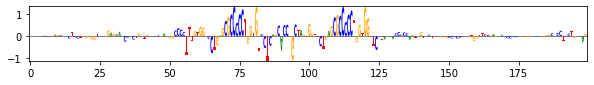

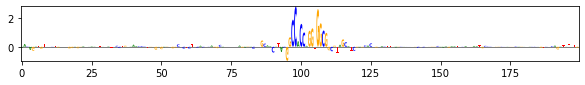

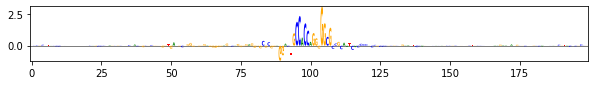

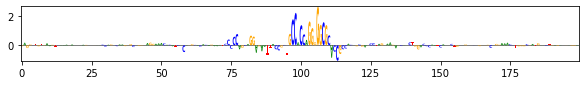

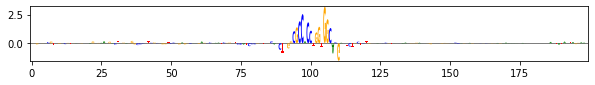

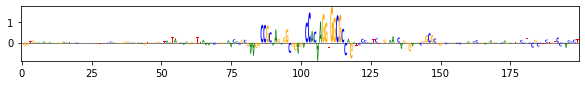

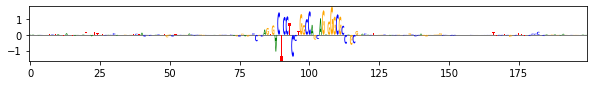

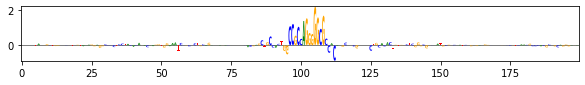

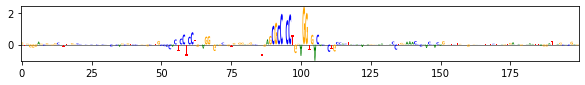

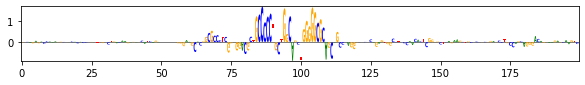

In [ ]:
import tensorflow.keras.backend as K

# create another op to calculate gradients of outputs with respect to inputs (i.e. saliency map)
# (we have to redo this because it's a different model)
gradients = model.optimizer.get_gradients(model.layers[-2].output, model.input)
compute_gradients = K.function(inputs=model.input, outputs=gradients)

# get model predictions for test sequences
predictions = model.predict(x_test)

# sort predictions in decending order
index = np.argsort(predictions[:,0])[::-1]

# get the top num_plot predictions
num_plots = 10
X = x_test[index[:num_plots]]

# calculate saliency maps
saliency_map = compute_gradients(X)[0]

# lets plot the saliency maps now
saliency_scores = saliency_map * X
for scores in saliency_scores:
  fig = plt.figure(figsize=(10,1))
  ax = plt.subplot(1,1,1)
  plot_saliency_map(scores, alphabet, ax)

Awesome! Now the saliency maps are much cleaner (i.e. less spurious noise) and the patterns resemble known CTCF motifs (both forward and reverse complements): https://www.factorbook.org/tf/human/CTCF/motif/ENCSR000BIE